# Explore NSF grant

## Data Incubator Challenge

The NSF released all its grant data in XML (https://nsf.gov/awardsearch/download.jsp). I propose to gather, analyze, and draw insights from the grant data. Several questions we can ask as initial exploration:
1. What is the funding history over 30 years?
2. How is the money distributed across the states?
3. How is the money distributed across research areas? Are there certain research areas that are more or less expensive?

(You can visit https://github.com/agnesbao/NSF_grant_tracker for script that download data from the website, and convert data from XML into csv file.)

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py

# Load data
dfall = pd.DataFrame()
for yr in range(1977,2018):
    folder = 'C:\\Users\\Agnes\\GoogleDrive\\WebScrapping\\NSF_script\\1977-2017_csv\\'
    fname = folder+str(yr)+'.csv'
    selected_columns = ['ARRAAmount','AwardAmount','AwardEffectiveDate',
       'AwardExpirationDate', 'AwardID','AwardInstrument',
       'Directorate', 'Division', 'Institution', 'CityName', 'StateName',
       'StateCode', 'CountryName']
    df = pd.read_csv(fname, usecols=selected_columns, encoding = "ISO-8859-1")
    df['FY'] = yr
    dfall = pd.concat([dfall, df],ignore_index=True)
dfall = dfall.drop_duplicates()

### 1. What is the funding history over 30 years?

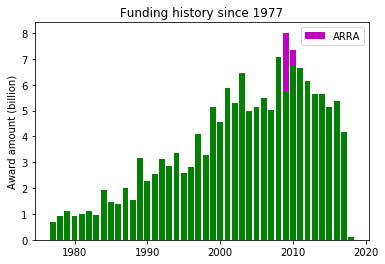

In [2]:
# Summarize award by year
eff_yr = dfall.AwardEffectiveDate.apply(lambda x: x[-4:]).astype(int)
eff_yr[eff_yr<1977]=np.nan
award_by_year = dfall.AwardAmount.groupby(eff_yr).sum()
arra_by_year = dfall.ARRAAmount.groupby(eff_yr).sum()
arra_by_year = arra_by_year.fillna(0)
plt.bar(award_by_year.index,award_by_year.values/1e9,color='m')
plt.bar(arra_by_year.index,award_by_year.values/1e9-arra_by_year.values/1e9,color='g')
plt.ylabel('Award amount (billion)')
plt.title('Funding history since 1977')
plt.legend(['ARRA'])
plt.show()

The annual award amount goes up and peaked at 2009, due to the American Recovery and Reinvestment Act, and has been decreasing after that. 

### 2. How is the money distributed across the states?
I am demonstrating the year of 2017 here. In the final result, I would like to put a drop-down menu to display different years as user chooses. 

In [5]:
# Summarize award by states
award_by_state = dfall.groupby([eff_yr,'StateCode','StateName']).AwardAmount

# prepare df in nsf_descriptive.py
df = award_by_state.sum().loc[2017]
text = df.index.get_level_values(1)+'<br>$'+(df/1e6).round(decimals=2).astype(str)+'M'\
        +'<br>Count: '+award_by_state.count().loc[2017].astype(str)
df = pd.DataFrame({'amount':df.values/1e6, 'text':text, 'state':df.index.get_level_values(1), \
                   'code':df.index.get_level_values(0)})

data = [ dict(
        type='choropleth',
        autocolorscale = True,
        locations = df.code,
        z = df.amount,
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Millions USD")
        ) ]

layout = dict(
        title = '2017 NSF Award Amount by State<br>(Hover for amount)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='nsf-2017-map' )

### 3. How is the money distributed across research areas? Are there certain research areas that are more or less expensive?

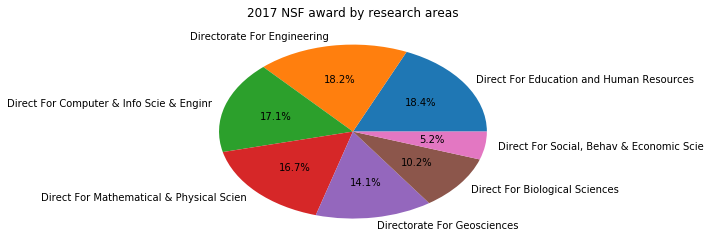

In [6]:
# Summarize award by research areas
award_by_directorate = dfall[eff_yr==2017].groupby(['Directorate']).AwardAmount
award_by_directorate_sum = award_by_directorate.sum().sort_values(ascending=False)
direct = award_by_directorate_sum.index.unique()
# Choose the main research areas
areas = direct[direct.str.contains('Direct For |Directorate')]
plt.pie(award_by_directorate_sum[areas], labels=award_by_directorate_sum[areas].index, autopct='%1.1f%%')
plt.title('2017 NSF award by research areas')
plt.show()

C:\Users\Agnes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:

modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.

C:\Users\Agnes\Anaconda3\lib\site-packages\pandas\core\generic.py:5233: SettingWithCopyWarning:

modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.



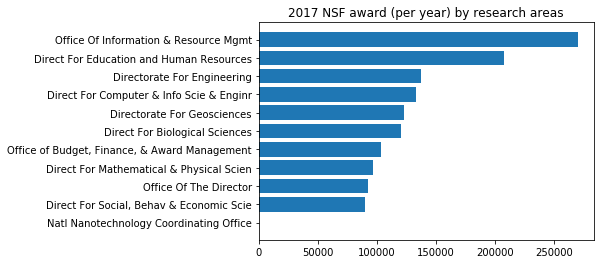

In [7]:
# Normalize amount by duration
award_dur = (pd.to_datetime(dfall.AwardExpirationDate)-pd.to_datetime(dfall.AwardEffectiveDate)).dt.days
award_dur[award_dur<=0] = np.nan
dfall['amount_per_year']=dfall.AwardAmount/(award_dur/365)
award_by_directorate_per_year = dfall[eff_yr==2017].groupby(['Directorate']).amount_per_year
per_year_mean = award_by_directorate_per_year.mean().sort_values()
plt.barh(range(len(per_year_mean)),per_year_mean,tick_label=per_year_mean.index)
plt.title('2017 NSF award (per year) by research areas')
plt.show()